# Learning Z/nZ x Z/nZ group actions
This notebook is adapted from the `modular arithmetic` notebook, replacing `Z/nZ` group action with `Z/nZ x Z/nZ` group action 

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
import setcwd
setcwd.main()

import gagf.models as models
import gagf.datasets as datasets
import gagf.theory as theory
import gagf.train as train
import gagf.viz as viz


Git root path:  /home/adele/code/group-agf

Working directory:  /home/adele/code/group-agf/gagf
Directory added to path:  /home/adele/code/group-agf
Directory added to path:  /home/adele/code/group-agf/gagf/notebooks


## Architecture

In [2]:
# class TwoLayerNet(nn.Module):
#     def __init__(self, p, hidden_size=None, nonlinearity='square', init_scale=1.0, output_scale=1.0):
#         super(TwoLayerNet, self).__init__()
        
#         # Store dimensions
#         self.p = p
#         if hidden_size is None:
#             hidden_size = 6 * p * p
#         self.hidden_size = hidden_size
#         self.nonlinearity = nonlinearity
#         self.init_scale = init_scale
#         self.output_scale = output_scale
#         self.group_size = p * p  # Since input is flattened p x p matrix
        
#         # Initialize parameters 
#         self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(2 * self.group_size))  # First p elements
#         self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(2 * self.group_size))  # Second p elements
#         self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(self.group_size)) # Second layer weights

#     def forward(self, x):
#         # First layer (linear and combined)
#         x1 = x[:, :self.group_size] @ self.U.T
#         x2 = x[:, self.group_size:] @ self.V.T
#         x_combined = x1 + x2

#         # Apply nonlinearity activation
#         if self.nonlinearity == 'relu':
#             x_combined = torch.relu(x_combined)
#         elif self.nonlinearity == 'square':
#             x_combined = x_combined**2
#         elif self.nonlinearity == 'linear':
#             x_combined = x_combined
#         elif self.nonlinearity == 'tanh':
#             x_combined = torch.tanh(x_combined)
#         elif self.nonlinearity == 'gelu':
#             gelu = torch.nn.GELU()
#             x_combined = gelu(x_combined)
#         else:
#             raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

#         # Second layer (linear)
#         x_out = x_combined @ self.W

#         # Feature learning scaling
#         x_out *= self.output_scale

#         return x_out

## Optimization

In [3]:
# def plot_neuron_weights(model, neuron_indices, p, save_path=None, show=False):
#     """
#     Plots the weights of specified neurons in the first linear layer of the model.
    
#     Args:
#         model: The neural network model (assumes first layer is nn.Linear).
#         neuron_indices: List of neuron indices to plot.
#         p: The value of p (weights are of size p*p).
#         save_path: Optional path to save the figure.
#     """
#     import matplotlib.pyplot as plt
#     import numpy as np

#     # Get the first linear layer's weights
#     first_layer = None
#     for module in model.modules():
#         if hasattr(module, 'weight') and hasattr(module, 'bias'):
#             first_layer = module
#             break
#     if first_layer is None:
#         raise ValueError("No linear layer with weights found in model.")

#     weights = first_layer.weight.detach().cpu().numpy()  # shape: (out_features, in_features)
#     fig, axs = plt.subplots(1, len(neuron_indices), figsize=(3*len(neuron_indices), 3))
#     if len(neuron_indices) == 1:
#         axs = [axs]
#     for i, idx in enumerate(neuron_indices):
#         w = weights[idx]  # shape: (p*p,)
#         if w.shape[0] != p*p:
#             raise ValueError(f"Expected weight size p*p={p*p}, got {w.shape[0]}")
#         # Reshape to (p, p)
#         w_img = w.reshape(p, p)
#         axs[i].imshow(w_img, cmap='viridis')
#         axs[i].set_title(f'Neuron {idx}')
#         axs[i].axis('off')
#     plt.tight_layout()
#     if save_path is not None:
#         plt.savefig(save_path, bbox_inches='tight')
#     if show:
#         plt.show()
#     plt.close(fig)

In [4]:
# def test_accuracy(model, dataloader):
#     correct = 0
#     total = 0
    
#     with torch.no_grad():  # Disable gradient calculation for evaluation
#         for batch_idx, (inputs, labels) in enumerate(dataloader):
#             inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
#             _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
#             correct += (predicted == true_labels).sum().item()
#             total += labels.size(0)
    
#     accuracy = 100 * correct / total
#     return accuracy

# def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=1, neurons_to_plot=[0,1,2, 3,4,5]):
#     model.train()  # Set the model to training mode
#     loss_history = []  # List to store loss values
#     accuracy_history = []
#     param_history = []

#     for epoch in range(epochs):
#         running_loss = 0.0
#         for batch_idx, (inputs, labels) in enumerate(dataloader):
#             # Check if labels are all zeros or if labels are not being set correctly
#             if torch.all(labels == 0):
#                 print(f"Warning: All labels are zero in batch {batch_idx} of epoch {epoch}")
#             if torch.isnan(inputs).any() or torch.isnan(labels).any():
#                 print(f"NaN detected in inputs or labels in batch {batch_idx} of epoch {epoch}")

#             inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers

#             optimizer.zero_grad()  # Zero gradients
#             outputs = model(inputs)  # Forward pass

#             # Check if outputs are all zeros or constant
#             if torch.all(outputs == 0):
#                 print(f"Warning: Model outputs are all zero in batch {batch_idx} of epoch {epoch}")

#             loss = criterion(outputs, labels)  # Compute loss

#             # Check if loss is zero from the start
#             if epoch == 0 and batch_idx == 0 and loss.item() == 0.0:
#                 print("Warning: Loss is zero at the very first batch. Check if criterion and labels are set up correctly.")

#             loss.backward()  # Backpropagation
#             optimizer.step()  # Update weights

#             running_loss += loss.item()

#         # Append the average loss for the epoch to loss_history
#         avg_loss = running_loss / len(dataloader)
#         loss_history.append(avg_loss)

#         # Append the accuracy
#         model.eval()
#         accuracy = test_accuracy(model, dataloader)
#         accuracy_history.append(accuracy)
#         model.train()

#         # Save current model parameters
#         current_params = {
#             "U": model.U.detach().cpu().clone(),
#             "V": model.V.detach().cpu().clone(),
#             "W": model.W.detach().cpu().clone()
#         }
#         param_history.append(current_params)

#         # Print verbose information every `verbose_interval` epochs
#         if (epoch + 1) % verbose_interval == 0:
#             print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

#         # Plot results every 100 epochs
#         if (epoch + 1) % 100 == 0:
#             print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')
#             model.eval()
#             with torch.no_grad():
#                 # Get one random example from the dataset
#                 idx = np.random.randint(len(dataloader.dataset))
#                 x, y = dataloader.dataset[idx]
#                 # If x is not already a tensor, convert it
#                 if not torch.is_tensor(x):
#                     x = torch.tensor(x, dtype=torch.float32)
#                 if not torch.is_tensor(y):
#                     y = torch.tensor(y, dtype=torch.float32)
#                 # Move to device if needed
#                 x_input = x.view(1, -1)
#                 if hasattr(model, 'device'):
#                     x_input = x_input.to(model.device)
#                 elif next(model.parameters()).is_cuda:
#                     x_input = x_input.cuda()
#                 output = model(x_input)
#                 output_np = output.cpu().numpy().squeeze()
#                 target_np = y.cpu().numpy().squeeze() if hasattr(y, 'cpu') else y.numpy().squeeze()

#                 # Try to infer image size if possible
#                 # Ensure x, output, and target are on CPU and numpy arrays for plotting
#                 if torch.is_tensor(x):
#                     x_np = x.detach().cpu().numpy()
#                 else:
#                     x_np = np.array(x)
#                 if torch.is_tensor(output):
#                     output_np = output.detach().cpu().numpy().squeeze()
#                 # output_np already defined above, but ensure it's on CPU and numpy
#                 if torch.is_tensor(y):
#                     target_np = y.detach().cpu().numpy().squeeze()
#                 else:
#                     target_np = np.array(y).squeeze()

#                 # Infer image size
#                 image_size = int(np.sqrt(x_np.shape[-1] // 2)) if x_np.shape[-1] % 2 == 0 else int(np.sqrt(x_np.shape[-1]))

#                 fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
#                 axs[0].imshow(x_np[:image_size*image_size].reshape(image_size, image_size))
#                 axs[0].set_title('Input 1')
#                 axs[1].imshow(x_np[image_size*image_size:].reshape(image_size, image_size))
#                 axs[1].set_title('Input 2')
#                 axs[2].imshow(output_np.reshape(image_size, image_size))
#                 axs[2].set_title('Output')
#                 axs[3].imshow(target_np.reshape(image_size, image_size))
#                 axs[3].set_title('Target')
#                 plt.tight_layout()
#                 plt.savefig(f"figs/prediction_fig_epoch_{epoch+1}.png", bbox_inches='tight')
#                 plt.close(fig)

#                 plot_neuron_weights(model, neurons_to_plot, p=image_size, save_path=f"figs/weights_epoch_{epoch+1}.png", show=False)

    
             

#     return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [5]:
# def style_axes(ax, numyticks=5, numxticks=5, labelsize=24):
#     # Y-axis ticks
#     ax.tick_params(axis="y", which="both", bottom=True, top=False,
#                    labelbottom=True, left=True, right=False,
#                    labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
#     ax.yaxis.set_major_locator(MaxNLocator(nbins=numyticks))
    
#     # X-axis ticks
#     ax.tick_params(axis="x", which="both", bottom=True, top=False,
#                    labelbottom=True, left=True, right=False,
#                    labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
#     ax.xaxis.set_major_locator(MaxNLocator(nbins=numxticks))

#     # Scientific notation formatting
#     if ax.get_yscale() == 'linear':
#         ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
#     if ax.get_xscale() == 'linear':
#         ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

#     ax.xaxis.offsetText.set_fontsize(20)
#     ax.grid()

#     # Customize spines
#     for spine in ["top", "right"]:
#         ax.spines[spine].set_visible(False)
#     for spine in ["left", "bottom"]:
#         ax.spines[spine].set_linewidth(3)

In [6]:
# def get_power_2d(points, no_freq=False):
#     """
#     Compute the 2D power spectrum of a real-valued array.

#     Note on redundant frequencies:
#     rfft2 removes redundant frequencies along first axis automatically
#     but does not truncate the second axis
#     Therefore, the output shape is (M, N//2 + 1).
#     This eliminates redundancy, save for a specific cases:
#     --> All frequencies along the first axis at (u, 0) for u = N//2 + 1, ..., N - 1
#     are redundant and contain the same information as (u, 0) for u = 1, ..., N//2 - 1.

#     Since most of the power coefficients now represnet 2 frequencies (positive and negative),
#     we double all the power coefficients to conserve total power.
#     However, we do not double the DC component (0, 0) and the Nyquist frequency (N/2, 0) if N is even,
#     since these are unique and do not have a negative counterpart.

#     Parameters
#     ----------
#     points : ndarray (M, N)
#         Real-valued 2D input array.

#     Returns
#     -------
#     freqs_u : ndarray (M,)
#         Frequency bins for the first axis (rows).
#     freqs_v : ndarray (N//2 + 1,)
#         Frequency bins for the second axis (columns).
#     power : ndarray (M, N//2 + 1)
#         Power spectrum of the input.
#     """
#     M, N = points.shape
#     num_coefficients = N // 2 + 1
    
#     # Perform 2D rFFT
#     ft = np.fft.rfft2(points)
    
#     # Power spectrum normalized by total number of samples
#     power = np.abs(ft)**2 / (M * N)

#     # For the first row (u=0), remove redundant frequencies and double the appropriate ones
#     power[(N//2 + 1):, 0] = 0 

#     # Since (almost) all frequencies contribute twice (positive and negative), double the power
#     power *= 2
#     # Except the DC component
#     power[0, 0] /= 2
#     # Except the Nyquist frequency if N is even
#     if N % 2 == 0:
#         power[N//2, 0] /= 2

#     # Check Parseval’s theorem
#     total_power = np.sum(power)
#     norm_squared = np.linalg.norm(points)**2
#     if not np.isclose(total_power, norm_squared, rtol=1e-3):
#         print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")


#     if no_freq:
#         return power

#     # Frequency bins
#     freqs_u = np.fft.fftfreq(M)          # full symmetric frequencies (rows)
#     freqs_v = np.fft.rfftfreq(N)         # only non-negative frequencies (columns)

#     return freqs_u, freqs_v, power


# def get_alpha_values_and_valid_freq(template):
#     p = int(np.sqrt(len(template)))
#     x_freq, y_freq, power = get_power_2d(template.reshape((p, p)))
#     print(power)
#     power = power.flatten()

#     valid = power > 1e-20
#     power = power[valid]
#     sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
#     power = power[sorted_idx]

#     # Plot theoretical lines
#     alpha_values = [np.sum(power[k:]) for k in range(len(power))]
#     coef = 1 / (p * p)
#     alpha_values = [alpha * coef for alpha in alpha_values]

#     return alpha_values, power, valid, sorted_idx


# def plot2D(ax, points, color, continuous, alpha=1.0):
#     # Adapted: points is a flattened square matrix. Un-flatten and plot as 2D signal.
#     n = int(np.sqrt(len(points)))
#     if n * n != len(points):
#         raise ValueError("Length of points is not a perfect square, cannot reshape to square matrix.")
#     mat = np.array(points).reshape((n, n))
#     im = ax.imshow(mat, cmap='viridis', interpolation='nearest', alpha=alpha)
#     # Optionally add a colorbar if desired:
#     # plt.colorbar(im, ax=ax)

## Template and Dataset Functions

In [7]:
# def one_hot2D(p):
#     """One-hot encode an integer value in R^pxp.
    
#     Parameters
#     ----------
#     p : int
#         p in Z/pZ x Z/pZ. Number of elements in the 2D modular addition
    
#     Returns
#     -------
#     mat : np.ndarray
#         A flattened one-hot encoded matrix of shape (p*p).
#     """
#     mat = np.zeros((p,p))
#     mat[0,0] = 1
#     mat = mat.flatten()
#     return mat

# def generate_fixed_template(p):
#     """Generate a fixed template for the 2D modular addition dataset.

#     Note: Since our input is a flattened matrix, we should un-flatten
#     the weights vectors to match the shape of the template when we visualize.
    
#     Parameters
#     ----------
#     p : int
#         p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition

#     Returns
#     -------
#     template : np.ndarray
#         A flattened 2D array of shape (p, p) representing the template.
#         After flattening, it will have shape (p*p,).
#     """
#     # Generate template array from Fourier spectrum
#     spectrum = np.zeros((p,p), dtype=complex)

#     # Three low-frequency bins with Gaussian-ish weights
#     v1 = 0.7 # 2.0
#     v2 = 1.0 #0.1 # make sure this is not too close to v1
#     v3 = 2.0 # 0.7 #0.01

#     plot_set_template_components(v1, v2, v3, p)

#     # Mode (1,0)
#     spectrum[1,0] = v1
#     spectrum[-1,0] = np.conj(v1) 

#     # Mode (2,1)
#     spectrum[0,1] = v2
#     spectrum[0,-1] = np.conj(v2)

#     # Mode (1,1)
#     spectrum[1,1] = v3
#     spectrum[-1,-1] = np.conj(v3)
    
#     # Generate signal from spectrum
#     template = np.fft.ifft2(spectrum).real

#     template = template.flatten()

#     return template


# def mnist_template(p):
#     """Generate a template from the MNIST dataset, resized to p x p.

#     Parameters
#     ----------
#     p : int
#         p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition
#     Returns
#     -------
#     template : np.ndarray
#         A flattened 2D array of shape (p, p) representing the template.
#     """
#     from sklearn.datasets import fetch_openml
#     from sklearn.model_selection import train_test_split
#     from sklearn.preprocessing import StandardScaler
#     from sklearn.decomposition import PCA
#     from sklearn.utils import shuffle
#     from skimage.transform import resize

#     # Load MNIST dataset
#     mnist = fetch_openml('mnist_784', version=1)
#     X = mnist.data.values
#     y = mnist.target.astype(int).values

#     # Filter for digit '0'
#     X_zero = X[y == 0]

#     # Shuffle and take one sample
#     X_zero = shuffle(X_zero, random_state=42)
#     sample = X_zero[0].reshape(28, 28)

#     # Resize to p x p
#     sample_resized = resize(sample, (p, p), anti_aliasing=True)

#     # Normalize to [0, 1]
#     sample_resized = (sample_resized - np.min(sample_resized)) / (np.max(sample_resized) - np.min(sample_resized))

#     plot_top_template_components(sample_resized, p)

#     template = sample_resized.flatten()

#     return template


# def plot_top_template_components(template_2d, p):
#     """Plot the top 5 Fourier components of the template.

#     Parameters
#     ----------
#     template : np.ndarray
#         A flattened 2D array of shape (p, p) representing the template.
#     p : int
#         p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition
#     """
#     freqs_u, freqs_v, power = get_power_2d(template_2d)

#     # Flatten the power array and get the indices of the top 5 components
#     power_flat = power.flatten()
#     top_indices = np.argsort(power_flat)[-5:][::-1]  # Indices of top 5 components

#     fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    
#     # Initialize cumulative spectrum
#     cumulative_spectrum = np.zeros_like(power, dtype=complex)
    
#     for i, idx in enumerate(top_indices):
#         u = idx // power.shape[1]
#         v = idx % power.shape[1]
        
#         # Add current component to cumulative spectrum
#         cumulative_spectrum[u, v] = np.sqrt(power[u, v] * p * p)  # Scale back to amplitude
#         if v != 0 and v != power.shape[1] - 1:
#             cumulative_spectrum[u, -v] = np.conj(cumulative_spectrum[u, v])  # Add negative frequency component if not DC or Nyquist
        
#         # Convert cumulative spectrum to spatial domain
#         spatial_component = np.fft.ifft2(cumulative_spectrum).real
        
#         # Create title showing which components are included
#         components_list = []
#         for j in range(i + 1):
#             comp_idx = top_indices[j]
#             comp_u = comp_idx // power.shape[1]
#             comp_v = comp_idx % power.shape[1]
#             components_list.append(f"({comp_u},{comp_v})")
        
#         title = f"Components: {', '.join(components_list)}\nNew: ({u},{v}) Power: {power[u,v]:.4f}"
        
#         # Roll the spatial component by half the image length in both x and y directions
#         spatial_component_rolled = np.roll(spatial_component, spatial_component.shape[0]//2, axis=0)
#         spatial_component_rolled = np.roll(spatial_component_rolled, spatial_component.shape[1]//2, axis=1)
        
#         im = axs[i].imshow(spatial_component_rolled, cmap='viridis')
#         axs[i].set_title(title)
#         plt.colorbar(im, ax=axs[i])
#     plt.tight_layout()
#     plt.show()


# def plot_set_template_components(v1, v2, v3, p):
#     spectrum = np.zeros((p,p), dtype=complex)

#     # Mode (1,0)
#     spectrum[1,0] = v1
#     spectrum[-1,0] = np.conj(v1) 

#     template_1 = np.fft.ifft2(spectrum).real

#     # Mode (0,1)
#     spectrum[0,1] = v2
#     spectrum[0,-1] = np.conj(v2)

#     template_2 = np.fft.ifft2(spectrum).real

#     # Mode (1,1)
#     spectrum[1,1] = v3
#     spectrum[-1,-1] = np.conj(v3)
    
#     # Generate signal from spectrum
#     template_full = np.fft.ifft2(spectrum).real

#     fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#     im1 = axs[0].imshow(template_1, cmap='viridis')
#     axs[0].set_title("Mode (1,0)")
#     plt.colorbar(im1, ax=axs[0])
#     im2 = axs[1].imshow(template_2, cmap='viridis')
#     axs[1].set_title("Mode (1,0)+(0,1)")
#     plt.colorbar(im2, ax=axs[1])
#     im3 = axs[2].imshow(template_full, cmap='viridis')
#     axs[2].set_title("Full Template")
#     plt.colorbar(im3, ax=axs[2])
#     plt.tight_layout()

#     plt.show()

# def ModularAdditionDataset2D(p, template, fraction=0.3, random_state=42):
#     """Generate a dataset for the 2D modular addition operation.

#     General idea: We are generating a dataset where each sample consists of 
#     two inputs (a*template and b*template) and an output (a*b)*template,
#     where a, b \in Z/pZ x Z/pZ. The template is a flattened 2D array
#     representing the modular addition operation in a 2D space.

#     Each element X_i will contain the template with a different a_i, b_i, and
#     in fact X contains the template at all possible a, b shifts.
#     The output Y_i will contain the template shifted by a_i*b_i.
#     * refers to the composition of two group actions (but by an abuse of notation, 
#     also refers to group action on the template. oops.)
    
#     Parameters
#     ----------
#     p : int
#         p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition.
#     template : np.ndarray
#         A flattened 2D array of shape (p*p,) representing the template.
#         This should be generated using `generate_fixed_template(p)`.
        
#     Returns
#     -------
#     X : np.ndarray
#         Input data of shape (p^4, 2, p*p). 
#         2 inputs (a and b), each with shape (p*p,).
#          is the total number of combinations of shifted a's and b's.
#     Y : np.ndarray
#         Output data of shape (p^4, p*p), where each sample is the result of the modular addition."""
#     # Initialize data arrays
#     X = np.zeros((p ** 4, 2, p * p))  # Shape: (p^4, 2, p*p)
#     Y = np.zeros((p ** 4, p * p))     # Shape: (p^4, p*p)
#     translations = np.zeros((p**4, 3, 2), dtype=int)
    
#     # Generate the dataset
#     idx = 0
#     template_2d = template.reshape((p, p))
#     for a_x in range(p):
#         for a_y in range(p):
#             for b_x in range(p):
#                 for b_y in range(p):
#                     q_x = (a_x + b_x) % p
#                     q_y = (a_y + b_y) % p
#                     X[idx, 0, :] = np.roll(np.roll(template_2d, a_x, axis=0), a_y, axis=1).flatten()
#                     X[idx, 1, :] = np.roll(np.roll(template_2d, b_x, axis=0), b_y, axis=1).flatten()
#                     Y[idx, :] = np.roll(np.roll(template_2d, q_x, axis=0), q_y, axis=1).flatten()
#                     translations[idx, 0, :] = (a_x, a_y)
#                     translations[idx, 1, :] = (b_x, b_y)
#                     translations[idx, 2, :] = (q_x, q_y)
#                     idx += 1

#     assert 0 < fraction <= 1.0, "fraction must be in (0, 1]"
#     N = X.shape[0]
#     n_sample = int(np.ceil(N * fraction))
#     rng = np.random.default_rng(random_state)
#     indices = rng.choice(N, size=n_sample, replace=False)

#     return X[indices], Y[indices], translations[indices]
            

# Define Dataset and Visualize

In [8]:
# def plot_template(template, template_minus_mean, indices, p, i=4):
#     template_matrix = template.reshape((p, p))
#     template_minus_mean_matrix = template_minus_mean.reshape((p, p))
#     translation = indices[i]
#     print(f"Translation for sample {i}: a=({translation[0][0]}, {translation[0][1]}), b=({translation[1][0]}, {translation[1][1]}), a+b=({translation[2][0]}, {translation[2][1]})")

#     Xi_a = X[i, 0].reshape((p, p))
#     Xi_b = X[i, 1].reshape((p, p))
#     Yi = Y[i].reshape((p, p))

#     # Plot the original template and the matrices
#     fig, axs = plt.subplots(1, 5, figsize=(16, 4))

#     # Plot the original template
#     im_template = axs[0].imshow(template_matrix, cmap='viridis')
#     axs[0].set_title("Original Template")
#     plt.colorbar(im_template, ax=axs[0])

#     im_template_minus_mean = axs[1].imshow(template_minus_mean_matrix, cmap='viridis')
#     axs[1].set_title("Template Minus Mean")
#     plt.colorbar(im_template_minus_mean, ax=axs[1])

#     # Extract translation values for titles
#     a_x, a_y = translation[0]
#     b_x, b_y = translation[1]
#     q_x, q_y = translation[2]

#     # Plot X[i][0] (a*template)
#     im0 = axs[2].imshow(Xi_a, cmap='viridis')
#     axs[2].set_title(f"X_a: Δx {a_x} Δy {a_y}")
#     axs[2].set_xlabel("y")
#     axs[2].set_ylabel("x")
#     plt.colorbar(im0, ax=axs[2])

#     # Plot X[i][1] (b*template)
#     im1 = axs[3].imshow(Xi_b, cmap='viridis')
#     axs[3].set_title(f"X_b: Δx {b_x} Δy {b_y}")
#     axs[3].set_xlabel("y")
#     axs[3].set_ylabel("x")
#     plt.colorbar(im1, ax=axs[3])

#     # Plot Y[i] ((a+b)*template)
#     im2 = axs[4].imshow(Yi, cmap='viridis')
#     axs[4].set_title(f"Y: Δx {q_x} Δy {q_y}")
#     axs[4].set_xlabel("y")
#     axs[4].set_ylabel("x")
#     plt.colorbar(im2, ax=axs[4])

#     plt.tight_layout()
#     plt.show()


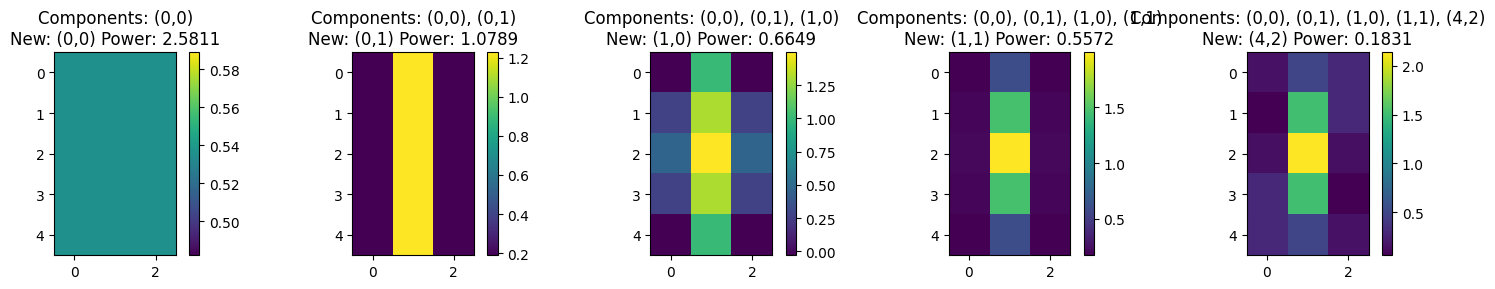

Template mean: 0.3213149373186612
Translation for sample 4: a=(1, 3), b=(4, 1), a+b=(0, 4)


NameError: name 'X' is not defined

In [9]:
# Data Generation using the new function
p = 5  # Modulus

# Choose template
# template = generate_template(p, 2, 1.0)
# template = one_hot2D(p)
og_template = datasets.mnist_template(p)
# og_template = generate_fixed_template(p)

print("Template mean:", np.mean(og_template))

# Mean center template
template = og_template - np.mean(og_template) # subtract the zeroth frequency

# Generate dataset using numpy
X, Y, indices = datasets.ModularAdditionDataset2D(p, template, fraction=1.0)
viz.plot_template(og_template, template, indices, p, i=4)

# Convert to PyTorch tensors
X_len = X.shape[-1]
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * X_len)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)
print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# Move tensors and model to the correct device if not already
X_tensor = X_tensor.to(device)
Y_tensor = Y_tensor.to(device)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

## Gradient Descent Experiment

In [ ]:
seed = 10 #0  # or any integer you like
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Initialize model
hidden_size = 6 * p * p  # 6 * size of group
init_scale = 1e-6 # 1e-2
model = models.TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=init_scale, output_scale=1e0)
model = model.to(device)

# Check if tensors and model are on the correct device (cuda or cpu)
print(f"X_tensor device: {X_tensor.device}")
print(f"Y_tensor device: {Y_tensor.device}")
print(f"Model device: {next(model.parameters()).device}")

# Create loss function
loss = nn.MSELoss()


# Construct optimizer
lr, mom = 0.0001, 0.5
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom) # TODO: try adam optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(mom, 0.999))

# Train the model
epochs = 100000#1
verbose_interval = 100
loss_history, accuracy_history, param_history = train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=verbose_interval)

X_tensor device: cuda:0
Y_tensor device: cuda:0
Model device: cuda:0
Epoch 100/100000, Loss: 0.1162, Accuracy: 3.68%
Epoch 100/100000, Loss: 0.116159


ValueError: No linear layer with weights found in model.

In [ ]:
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump({
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "param_history": param_history
    }, f)

print("Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).")



Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).


## Plot Loss

p: 5
[[7.88860905e-33 1.07892936e+00 9.07007621e-02]
 [6.64898672e-01 5.57203551e-01 1.46719989e-02]
 [1.00958610e-01 2.63696505e-02 3.02612407e-02]
 [0.00000000e+00 9.92355049e-02 2.81824912e-02]
 [0.00000000e+00 2.94999572e-02 1.83072413e-01]]
[ 0.   0.2  0.4 -0.4 -0.2]
[0.  0.2 0.4]


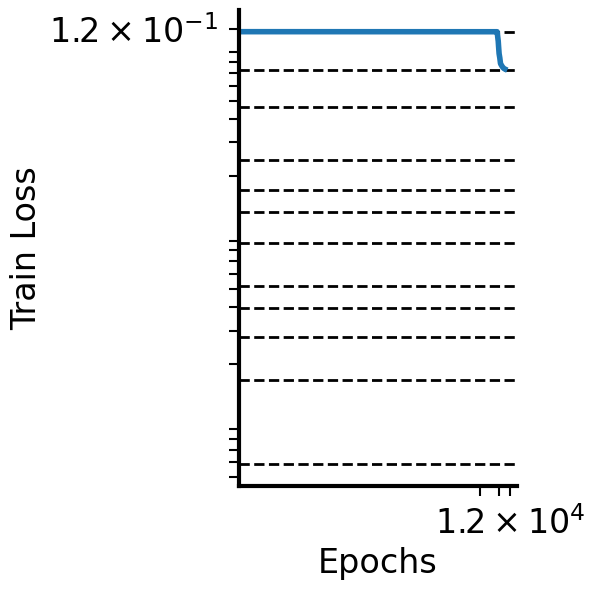

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)


# === Compute power spectrum of template ===
p = int(np.sqrt(len(template)))
print("p:", p)
x_freq, y_freq, power = theory.get_power_2d(template.reshape((p, p)))
print(power)
print(x_freq)
print(y_freq)
power = power.flatten()

valid = power > 1e-20
power = power[valid]
sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
power = power[sorted_idx]

# Plot theoretical lines
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / (p * p)

# alpha_values = get_alpha_values(template)

for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef*alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1e-2, 1e0)

ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

viz.style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

In [ ]:
# def model_power_over_time(model, template_power_length, valid_freqs=None):
#     """Compute the power spectrum of the model's learned weights over time.

#     Parameters
#     ----------
#     model : TwoLayerNet
#         The trained model.
#     valid_freqs : list of tuple, optional
#         List of frequency indices to track. If None, track all frequencies.

#     Returns
#     -------
#     avg_power_history : list of ndarray (num_steps, num_freqs)
#         List of average power spectra at each step.
#     """
#     # Compute output power over time (GD)
#     num_points = 1000
#     steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
#     powers_over_time = np.zeros([len(steps), template_power_length])  # shape: (steps, num_freqs) np.zeros([len(steps), len(X_tensor), template_power_length]) 
#     # powers_over_time = np.zeros([len(steps), len(X_tensor), template_power_length]) 

#     for i_step, step in enumerate(steps):
#         model.load_state_dict(param_history[step])
        
#         model.eval()
#         with torch.no_grad():
#             outputs = model(X_tensor)
#             # Compute 2D FFT for each output, then flatten and take rfft2
#             outputs_2d = outputs.detach().cpu().numpy().reshape(-1, p, p)
#             powers = np.array([get_power_2d(out, no_freq=True) for out in outputs_2d])
#             # Don't flatten the batch dim; keep as (num_samples, p* p//2 + 1)
#             powers = powers.reshape(outputs_2d.shape[0], -1)
#             average_power = np.mean(powers, axis=0)
#             powers_over_time[i_step, :] = average_power

#     powers_over_time = np.array(powers_over_time)  # shape: (steps, num_freqs)
#     print("Powers over time shape:", powers_over_time.shape)

#     if valid_freqs is not None:
#         valid_indices = [idx for idx, freq in enumerate(freq_tuples) if freq in valid_freqs]
#         powers_over_time = powers_over_time[:, valid_indices]
#         print(f"Filtered to {len(valid_indices)} valid frequencies.")
    
#     return powers_over_time, steps
    

p = 5
freq shape: (15, 2)
power shape: (5, 3)
Template power shape: (15,)
[[7.88860905e-33 1.07892936e+00 9.07007621e-02]
 [6.64898672e-01 5.57203551e-01 1.46719989e-02]
 [1.00958610e-01 2.63696505e-02 3.02612407e-02]
 [0.00000000e+00 9.92355049e-02 2.81824912e-02]
 [0.00000000e+00 2.94999572e-02 1.83072413e-01]]
Flattened_template_power [7.88860905e-33 1.07892936e+00 9.07007621e-02 6.64898672e-01
 5.57203551e-01 1.46719989e-02 1.00958610e-01 2.63696505e-02
 3.02612407e-02 0.00000000e+00 9.92355049e-02 2.81824912e-02
 0.00000000e+00 2.94999572e-02 1.83072413e-01]
Valid indices: [False  True  True  True  True  True  True  True  True False  True  True
 False  True  True]
Sorted indices: [ 0  2  3 11  5  8  1  7 10  9  6  4]
15
Powers over time shape: (599, 15)


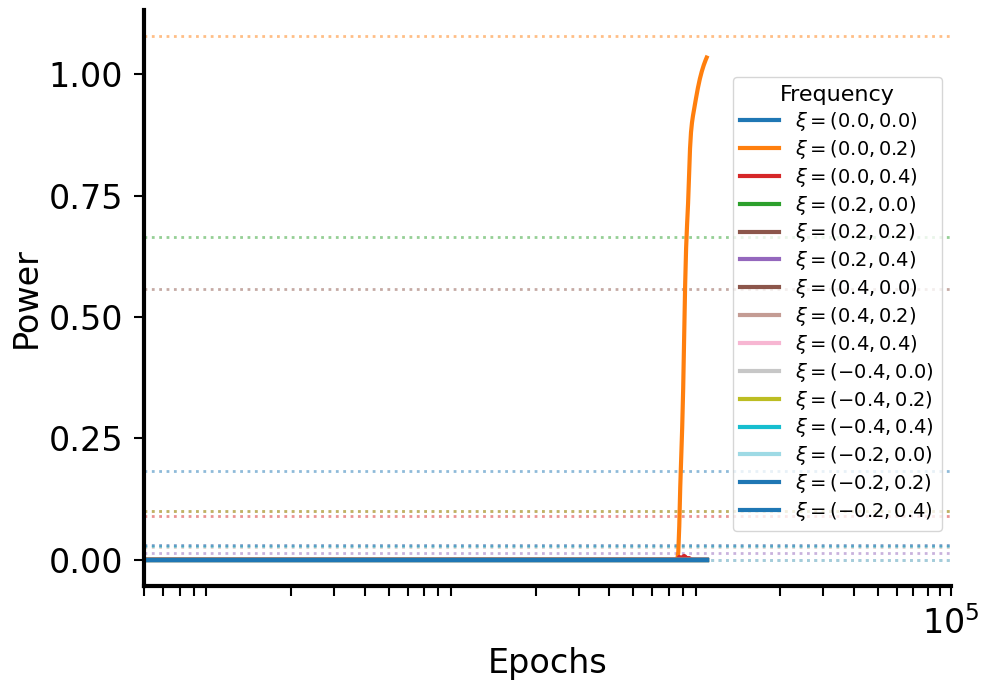

In [ ]:
# === SETTINGS ===
print("p =", p)
pxp = p * p
num_freqs = pxp // 2 + 1

# Compute template power spectrum (flattened 2D)
template_2d = template.reshape((p, p))
template_ft_2d = np.fft.rfft2(template_2d)
# template_power_2d = np.abs(template_ft_2d).flatten()[:num_freqs]

# === Compute power spectrum of template ===
freqs_u, freqs_v, template_power = theory.get_power_2d(template_2d)
freq = np.array([(u, v) for u in freqs_u for v in freqs_v])
print("freq shape:", freq.shape)
print("power shape:", template_power.shape)
# freq_flattened = freq.flatten()
# print("freq_flattened shape:", freq_flattened.shape)
flattened_template_power = template_power.flatten()
print("Template power shape:", flattened_template_power.shape)

alpha_values, flattened_filtered_template_power, valid_flattened_power_indices, sorted_valid_idx = get_alpha_values_and_valid_freq(template)
print("Flattened_template_power", flattened_template_power)
print("Valid indices:", valid_flattened_power_indices)
print("Sorted indices:", sorted_idx)

# coef = 1 / p
# theta0 = np.sqrt(2) * model.init_scale
# uMax = [np.sqrt(2 * p / 27) * (p * power[k] / 2)**(3/2) / p**2 for k in range(len(power))]
# tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
# step_size = 2 * coef * lr / (1 - mom)

# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

print(len(template_power.flatten()))
model_powers_over_time, steps = theory.model_power_over_time(model, len(template_power.flatten())) # models_powers_over_time shape: (num_steps, num_freqs), includes all frequencies in rfft

# === PLOTTING ===
fig, ax = plt.subplots(figsize=(10, 7))

# # Identify the indices of the top 5 frequencies in the template's power spectrum
# top_k = 5
# top_freq_indices =        # descending order
# print("Top frequency indices:", top_freq_indices)

# For labeling, get the (u, v) frequency pairs for these indices
# freq is an array of shape (num_freqs, 2)
# top_freq_labels = [fr"$\xi = ({freq[k][0]}, {freq[k][1]})$" for k in valid_power_indices]

for i in range(len(freq)):
    color = colors[i] if i < len(colors) else colors[0]
    label = fr"$\xi = ({freq[i][0]}, {freq[i][1]})$"
    ax.plot(steps, model_powers_over_time[:, i], color=color, lw=3, label=label)
    ax.axhline(flattened_template_power[i], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

# for i, k in enumerate(top_freq_indices):
#     color = colors[i] if i < len(colors) else colors[0]
#     tau = tau_values[k]
#     x = tau / step_size
#     y = template_power[k]
#     ax.axvline(x=x, color=color, linestyle='dashed', linewidth=2, alpha=0.5)
#     # Add arrow at intersection
#     ax.arrow(1.04 * x, y + 0.5, 1.5 * x, 0, 
#              head_width=0.2, head_length=x*0.2, length_includes_head=True,
#              fc=color, ec=color, lw=4)

# # Add vertical lines if needed
# for step in time_steps:
#     ax.axvline(x=step, color='gray', alpha=0.5, linestyle='solid', linewidth=2)

# Labeling and formatting
ax.set_xscale('log')
ax.set_xlim(5e1, len(param_history) - 1)
ax.set_xticks([1000, 10000, 100000, len(param_history) - 1])
ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', 'Final'])
ax.set_ylabel("Power", fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

viz.style_axes(ax)
ax.grid(False)
plt.tight_layout()
plt.savefig("fourier_power_only.pdf", bbox_inches="tight")
plt.show()

## Plot outputs
TODO: un-flatten predicted signals. First column is ground truth, second column is predicted signal, third column is MSE between them.

IndexError: list index out of range

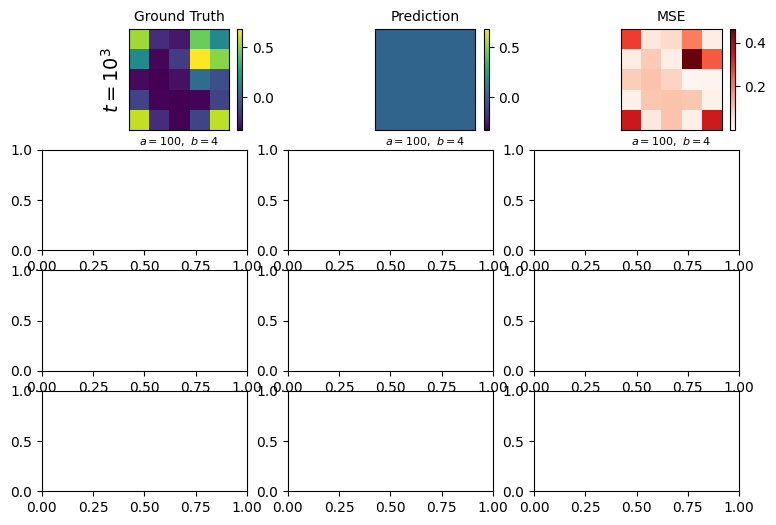

In [ ]:
import matplotlib.pyplot as plt

# Choose time steps to visualize
steps_to_show = [1000, 10000, 100000, epochs-1]
num_samples = 1  # how many examples to plot per row

# For 2D: p is the side length, output is flattened p*p
p = int(np.sqrt(Y_tensor.shape[1]))
x = np.arange(p)

fig, axes = plt.subplots(len(steps_to_show), num_samples * 3, figsize=(9, 6), sharex=False)

if len(axes.shape) == 1:
    axes = axes[None, :]  # ensure axes is 2D

for row, step in enumerate(steps_to_show):
    # Load weights at this step
    model.load_state_dict(param_history[step])
    model.eval()

    indices = np.random.choice(len(Y_tensor), size=num_samples, replace=False)
    with torch.no_grad():
        preds = model(X_tensor[indices]).detach().cpu().numpy()
        truths = Y_tensor[indices].detach().cpu().numpy()

    for i, idx in enumerate(indices):
        a = idx // p
        b = idx % p

        # Unflatten for 2D
        truth_2d = truths[i].reshape(p, p)
        pred_2d = preds[i].reshape(p, p)
        mse_2d = (truth_2d - pred_2d) ** 2

        # Plot ground truth
        ax_true = axes[row, i*3 + 0]
        im0 = ax_true.imshow(truth_2d, cmap='viridis', vmin=truth_2d.min(), vmax=truth_2d.max())
        ax_true.set_title("Ground Truth", fontsize=10)
        plt.colorbar(im0, ax=ax_true, fraction=0.046, pad=0.04)
        ax_true.set_xticks([])
        ax_true.set_yticks([])

        # Plot prediction
        ax_pred = axes[row, i*3 + 1]
        im1 = ax_pred.imshow(pred_2d, cmap='viridis', vmin=truth_2d.min(), vmax=truth_2d.max())
        ax_pred.set_title("Prediction", fontsize=10)
        plt.colorbar(im1, ax=ax_pred, fraction=0.046, pad=0.04)
        ax_pred.set_xticks([])
        ax_pred.set_yticks([])

        # Plot MSE
        ax_mse = axes[row, i*3 + 2]
        im2 = ax_mse.imshow(mse_2d, cmap='Reds')
        ax_mse.set_title("MSE", fontsize=10)
        plt.colorbar(im2, ax=ax_mse, fraction=0.046, pad=0.04)
        ax_mse.set_xticks([])
        ax_mse.set_yticks([])

        # Only leftmost column gets ylabel
        ax_true.set_ylabel(fr"$t = 10^{{{int(np.log10(step))}}}$", fontsize=14)

        # Optionally, annotate with a, b
        for ax in [ax_true, ax_pred, ax_mse]:
            ax.set_xlabel(fr"$a = {a},\ b = {b}$", fontsize=8)

plt.tight_layout()
plt.savefig("predictions_2d.pdf", bbox_inches='tight')

## Plot Weights
TODO: un-flatten the weights, frequencies and phases can stay in vector I think.

/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/Users/danielkunin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


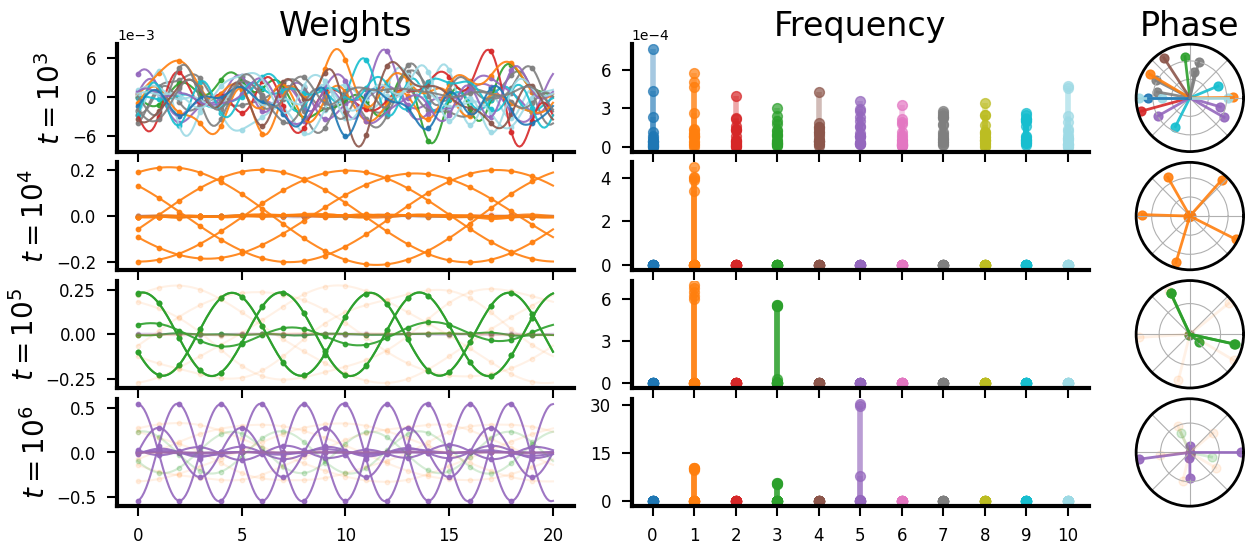

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Steps and corresponding highlighted frequencies

steps = [1000, 10000, 100000, epochs-1]
highlight_freqs_list = [[], [1], [3], [5]]

num_rows, num_cols = len(steps), 3

# Use gridspec to control layout
fig = plt.figure(figsize=(24, 6), constrained_layout=True)
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1.1, 1.1, 2.0], wspace=0.1, hspace=0.1)
axes = np.empty((num_rows, num_cols), dtype=object)

# Create axes
for row in range(num_rows):
    for col in range(num_cols):
        if col == 2:
            ax = fig.add_subplot(gs[row, col], projection='polar')
        else:
            ax = fig.add_subplot(gs[row, col])  # ⬅ no sharex anymore
        axes[row, col] = ax

num_freqs = None
for row, index in enumerate(steps):
    highlight_freqs = highlight_freqs_list[row]
    params = param_history[index]
    W = params['W'].numpy()
    h, p = W.shape

    if num_freqs is None:
        num_freqs = p // 2 + 1
        cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
        colors = [cmap(i) for i in range(num_freqs)]
        manual_colors = {
            0: 'tab:blue',
            1: 'tab:orange',
            2: 'tab:red',
            3: 'tab:green',
            4: 'tab:brown',
            5: 'tab:purple',
        }
        freq_colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]


    # === Column 1: Weights ===
    ax = axes[row, 0]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        x = np.linspace(0, p - 1, 500)
        plot2D(ax, w, color=color, continuous=True, alpha=alpha)
        # ax.scatter(np.arange(p), w, color=color, s=10, alpha=alpha)
    if row == 0: ax.set_title("Weights", fontsize=24)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(index))}}}$", fontsize=20)
    style_axes(ax, numyticks=3, numxticks=5, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 2: Frequency Spectrum ===
    ax = axes[row, 1]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        for k in range(len(power)):
            color = freq_colors[k]
            ax.vlines(k, 0, power[k], linewidth=4, color=color, alpha=0.4)
            ax.scatter(k, power[k], color=color, s=50, alpha=0.7)
    # ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.4)
    ax.set_xlim(-0.5, len(power) - 0.5)
    ax.set_xticks(np.arange(len(power)))
    if row == 0: ax.set_title("Frequency", fontsize=24)
    style_axes(ax, numyticks=3, numxticks=11, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 3: Phase Polar Plot ===
    ax = axes[row, 2]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        phase = np.angle(ft[dom_idx])
        norm = np.linalg.norm(w)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        ax.plot([phase, phase], [0, norm], color=color, linewidth=2, alpha=alpha)
        ax.scatter(phase, norm, color=color, s=40, alpha=alpha)
        angles = np.arange(0, 360, 45)
        # ax.set_thetagrids(angles, [f"{a}°" if a in [45,135,225,315] else "" for a in angles])
        ax.set_thetagrids(angles, ["" for a in angles])
        ax.set_yticklabels([])
        ax.spines['polar'].set_linewidth(2)
    if row == 0: ax.set_title("Phase", fontsize=24)

# Shift polar plots left to reduce whitespace
for row in range(num_rows):
    ax = axes[row, 2]
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.155, pos.y0, pos.width, pos.height])

plt.savefig("W-weights.pdf", bbox_inches='tight')